In [1]:
!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install --upgrade ipykernel google-colab > /dev/null 2>&1

In [2]:
import base64
import glob
import io
import random
import shutil
from collections import deque, namedtuple
from copy import deepcopy

import gym

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython import display as ipythondisplay
from IPython.display import HTML
from pyvirtualdisplay import Display
from tqdm import trange

*Epsilon-gready strategy class*

In [3]:
class EpsilonStrategy:
    def __init__(self, start=1, decay=.999985, min_eps=0.02):
        self.eps = start
        self.decay = decay
        self.start = start
        self.min_eps = min_eps

    def eps(self):
        return self.eps

    def decrease(self):
        self.eps = max(self.eps * self.decay, self.min_eps)

    def check_random_prob(self):
        return np.random.random() < self.eps

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


*Experience buffer class*

In [4]:
Transition = namedtuple(typename='Transition',
                        field_names=['state', 'next_state', 'action', 'reward', 'terminal'])

class ExperienceBuffer:
    def __init__(self, capacity=10_000, batch_size=32, start_sample_from=10_000):
        capacity = int(capacity)
        batch_size = int(batch_size)
        start_sample_from = int(start_sample_from)

        if batch_size > capacity:
            raise AssertionError('random sample size should be <= size')

        if batch_size > start_sample_from:
            raise AssertionError('start sample from should be >= batch_size')

        self.buffer = deque(maxlen=capacity)
        self.capacity = capacity
        self.batch_size = batch_size
        self.batch_indices = np.arange(self.batch_size)
        self.start_sample_from = start_sample_from

    def __len__(self):
        return len(self.buffer)

    def sample(self):
        if not self.is_ready_for_sample():
            raise AssertionError('Buffer have is not ready for sample')

        indices = np.random.choice(len(self.buffer), self.batch_size, replace=False)
        states, next_states, actions, rewards, terminals = zip(*[self.buffer[i] for i in indices])
        return (np.array(states),
                np.array(next_states),
                np.array(actions, dtype=np.int64),
                np.array(rewards, dtype=np.float32),
                np.array(terminals, dtype=np.uint8))

    def push(self, transition: Transition):
        self.buffer.append(transition)

    def is_ready_for_sample(self):
        return len(self.buffer) >= self.start_sample_from

*Dqn Agent*

In [5]:
class DqnAgent:
    def __init__(
        self,
        net: nn.Module,
        lr: float,
        gamma: float,
        update_model_freq: int,
        buffer: ExperienceBuffer,
        eps_strategy: EpsilonStrategy,
        device: str = "cuda"
    ):
        self.source_net = deepcopy(net).to(device)
        self.target_net = deepcopy(net).to(device).eval()
        self.lr = lr
        self.gamma = gamma
        self.device = device
        self.update_model_freq = update_model_freq
        self.buffer = buffer
        self.eps_strategy = eps_strategy

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.source_net.parameters(), lr=lr)

    def eval(self):
        self.source_net.eval()

    def train(self):
        self.source_net.train()

    @torch.no_grad()
    def act(self, state: np.ndarray) -> int:
        self.source_net.eval()
        numpy_state  = np.array([state], copy=False)
        tensor_state = torch.FloatTensor(numpy_state).to(self.device)
        q_values     = self.source_net(tensor_state)
        action       = torch.argmax(q_values).item()
        self.source_net.train()
        return action

    def learn(self, env, epochs: int):
        progress = trange(epochs, desc="Epochs")

        ema_reward = None
        rewards = []

        step = 0

        for epoch in progress:
            state = env.reset()
            terminal = False
            ep_reward = 0

            while not terminal:
                action = self._epsilon_act(state, env)
                next_state, reward, terminal, _, _ = env.step(action)

                transition = Transition(
                    state=state,
                    next_state=next_state,
                    action=action,
                    reward=reward,
                    terminal=terminal
                )

                self.buffer.push(transition)
                self._learn_episode(step)

                step += 1
                ep_reward += 1
                self.eps_strategy.decrease()
                state = next_state

                if ep_reward == 500:
                    break

            rewards.append(ep_reward)
            if ema_reward is None:
                ema_reward = ep_reward
            else:
                ema_reward = 0.9 * ema_reward + 0.1 * ep_reward

            progress.set_postfix({"EMA reward": ema_reward})

        return rewards

    def _learn_episode(self, episode: int):
        """
        Trains Q-function net.
        Using fixed target-model to predict target Q-function and q-model to choose actions while training.
        """
        if not self.buffer.is_ready_for_sample():
            return

        states, next_states, actions, rewards, terminals = self._sample_batch()

        q_eval = self.source_net(states)[self.buffer.batch_indices, actions]

        with torch.no_grad():
            q_future = self.target_net(next_states).max(dim=1).values
            q_future[terminals] = 0.0
            q_target = rewards + self.gamma * q_future

        self._gradient_step(q_eval, q_target)

        if episode % self.update_model_freq == 0:
            self.target_net.load_state_dict(self.source_net.state_dict())
            self.target_net.eval()

    def _epsilon_act(self, state: np.ndarray, env) -> int:
        """
        Represents eps-greedy selection according to given eps-strategy.
        """
        if self.eps_strategy.check_random_prob():
            return env.action_space.sample()
        else:
            return self.act(state)

    def _sample_batch(self):
        """
        :return: ( [states], [next_states], [actions], [rewards], [is_done] )
        """
        states, next_states, actions, rewards, terminals = self.buffer.sample()
        return [
            torch.FloatTensor(states).to(self.device),
            torch.FloatTensor(next_states).to(self.device),
            torch.LongTensor(actions).to(self.device),
            torch.FloatTensor(rewards).to(self.device),
            torch.BoolTensor(terminals).to(self.device)
        ]

    def _gradient_step(self, q_eval: torch.Tensor, q_target: torch.Tensor):
        loss = self.criterion(q_eval, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

*Q network*

In [6]:
class DenseNet(nn.Module):
    def __init__(self, space_dim: int, action_dim: int):
        super().__init__()
        self.lbr1 = nn.Sequential(
            nn.Linear(space_dim, 32),
            nn.BatchNorm1d(32),
            nn.Tanh()
        )
        self.lbr2 = nn.Sequential(
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.Tanh()
        )
        self.regressor = nn.Linear(64, action_dim)

    def forward(self, x):
        x = self.lbr1(x)
        x = self.lbr2(x)
        x = self.regressor(x)
        return x

*Compose all together*

In [7]:
buffer = ExperienceBuffer(
    capacity=50_000,
    batch_size=512,
    start_sample_from=1000,
)

eps_strategy = EpsilonStrategy(
    decay=0.9995,
    min_eps=0.01
)

net = DenseNet(space_dim=4, action_dim=2)

agent = DqnAgent(
    net=net,
    lr=1e-4,
    gamma=0.99,
    update_model_freq=200,
    buffer=buffer,
    eps_strategy=eps_strategy,
    device="cuda"
)

In [8]:
env = gym.make("CartPole-v1", new_step_api=True)
rewards = agent.learn(env, epochs=300)

Epochs: 100%|██████████| 300/300 [01:43<00:00,  2.91it/s, EMA reward=484]


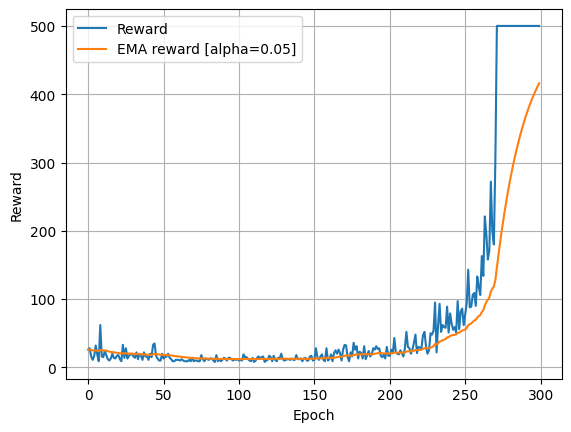

In [9]:
def ema(x, alpha):
    emas = [x[0]]
    for v in x[1:]:
        emas.append(emas[-1] * (1 - alpha) + alpha * v)

    return emas

plt.grid()
plt.plot(rewards, label="Reward")
plt.plot(ema(rewards, 0.05), label="EMA reward [alpha=0.05]")
plt.xlabel("Epoch")
plt.ylabel("Reward")
plt.legend()
plt.show()

*Show example of final agent controlling*

In [10]:
display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                    </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def play(dqn, enviroment):
    enviroment = gym.wrappers.record_video.RecordVideo(enviroment, "./video")
    state = enviroment.reset()
    total = 0
    while True:
        enviroment.render()
        action = dqn.act(state)
        next_state, reward, done, _ = enviroment.step(action)
        state = next_state
        total += reward
        if done:
            enviroment.close()
            show_video()
            return total

In [11]:
play(agent, env)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarni

500.0